In [28]:
# Import packages
import warnings
warnings.filterwarnings('ignore')
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import gc
import os
from tqdm.notebook import tqdm

In [29]:
# Load the data
calendar = pd.read_csv( "calendar.csv")
selling_prices = pd.read_csv("sell_prices.csv")
sample_submission = pd.read_csv("sample_submission.csv")
sales = pd.read_csv("sales_train_validation.csv")

In [30]:
# Create a new variable for sales to do EDA
train_sales = pd.read_csv("sales_train_validation.csv")

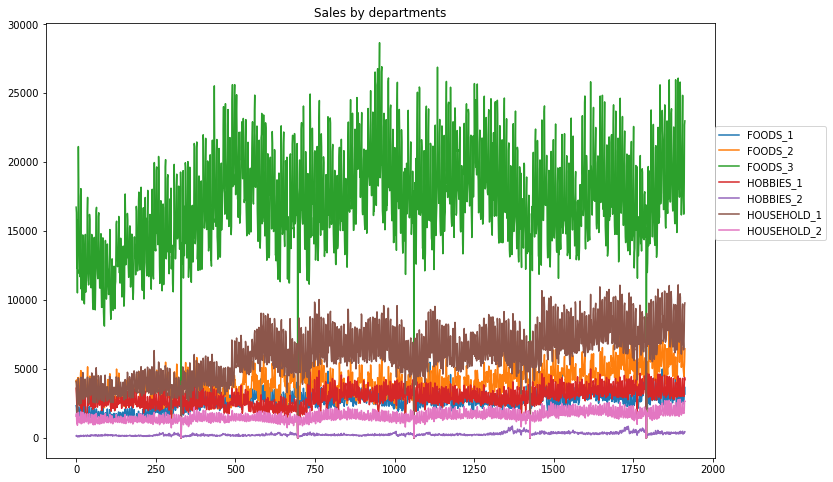

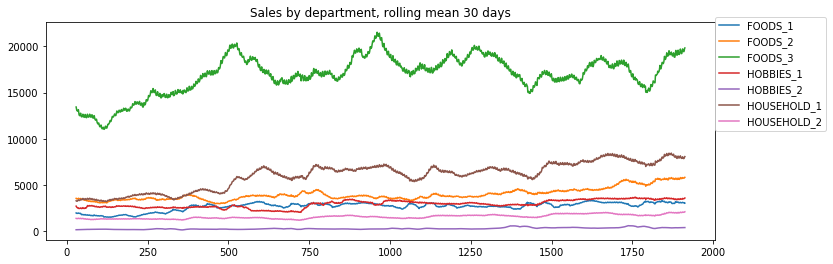

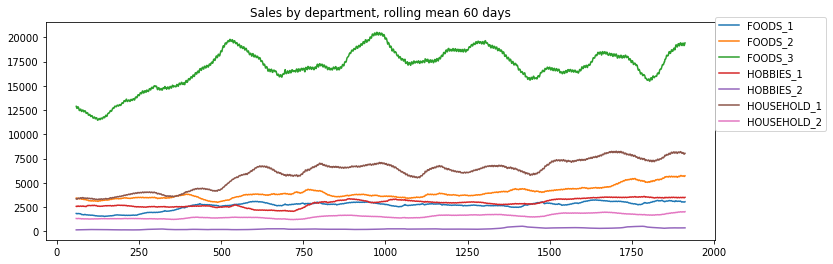

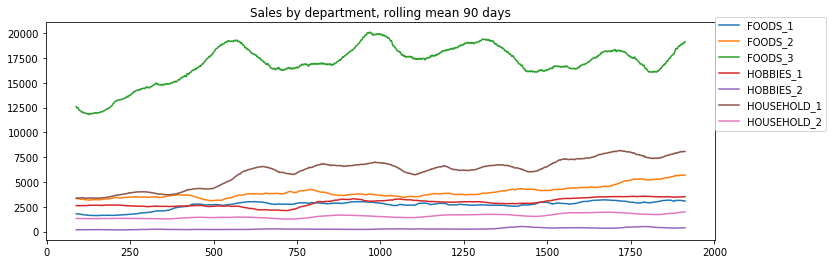

In [35]:
# Sales by departments (with rolling mean 30,60 and 90)
plt.figure(figsize=(12, 8))
dept_grouped_sales = train_sales.groupby(['dept_id']).sum()
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.values, label=i);
plt.legend(loc=(1.0, 0.5))
plt.title('Sales by departments');

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(30).mean().values, label=i);
plt.title('Sales by department, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(60).mean().values, label=i);
plt.title('Sales by department, rolling mean 60 days')
plt.legend(loc=(1.0, 0.5));

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(90).mean().values, label=i);
plt.title('Sales by department, rolling mean 90 days')
plt.legend(loc=(1.0, 0.5));

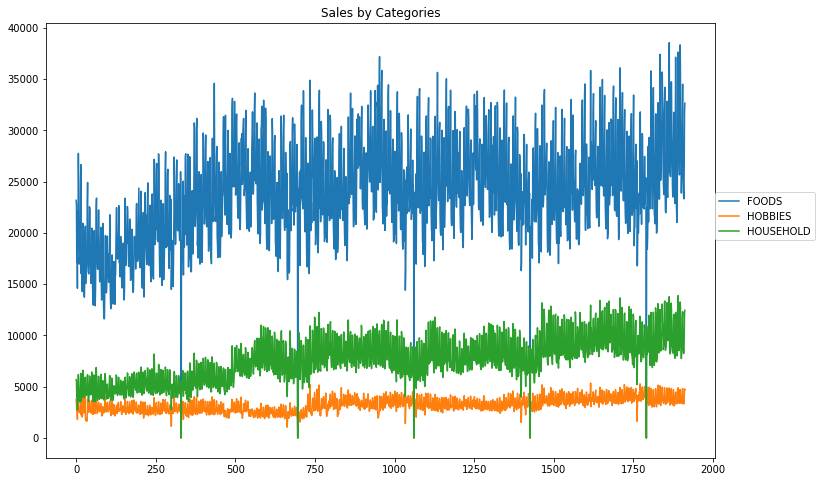

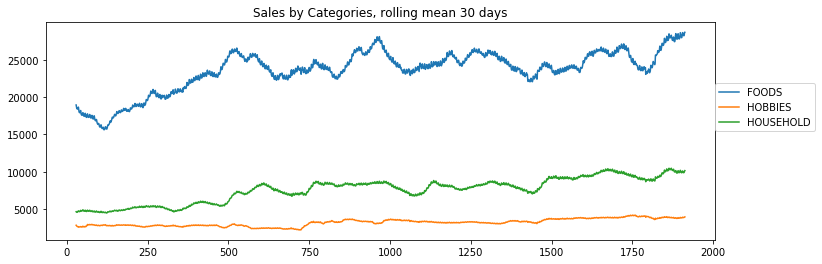

In [36]:
# Sales by Categories (with rolling mean 30)
plt.figure(figsize=(12, 8))
dept_grouped_sales = train_sales.groupby(['cat_id']).sum()
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.values, label=i);
plt.legend(loc=(1.0, 0.5))
plt.title('Sales by Categories');

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(30).mean().values, label=i);
plt.title('Sales by Categories, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

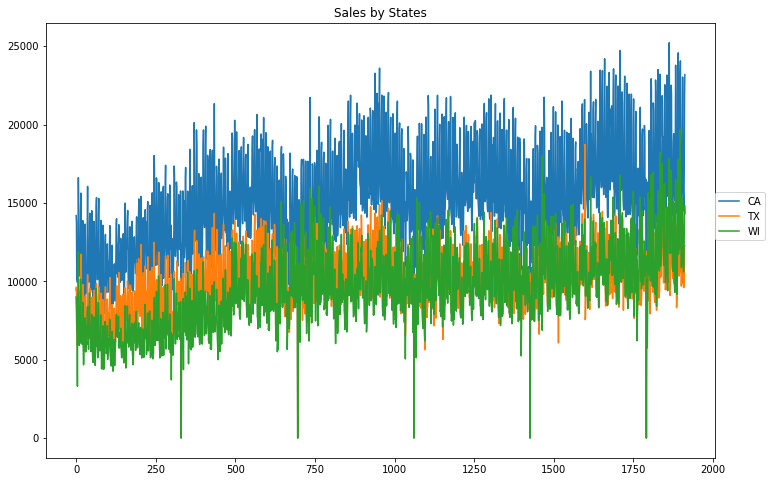

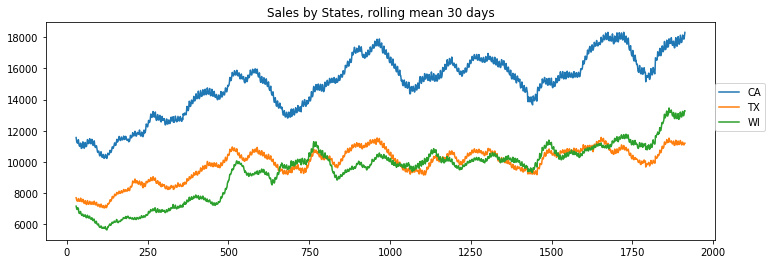

In [37]:
# Sales by States (with rolling mean 30)
plt.figure(figsize=(12, 8))
dept_grouped_sales = train_sales.groupby(['state_id']).sum()
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.values, label=i);
plt.legend(loc=(1.0, 0.5))
plt.title('Sales by States');

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(30).mean().values, label=i);
plt.title('Sales by States, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

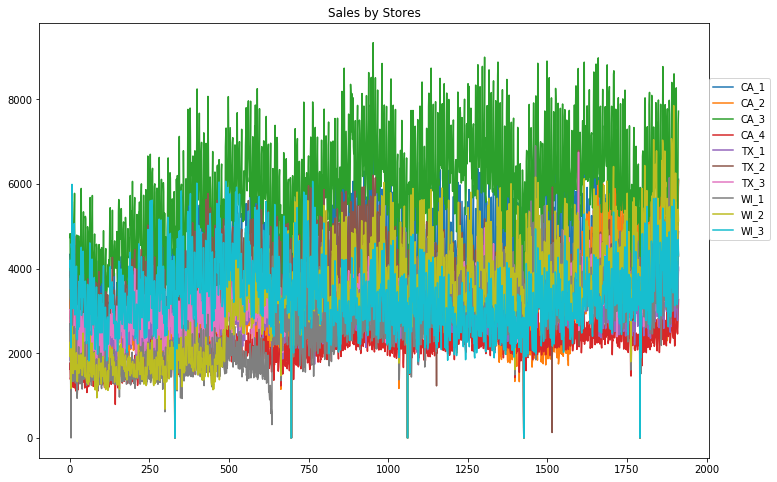

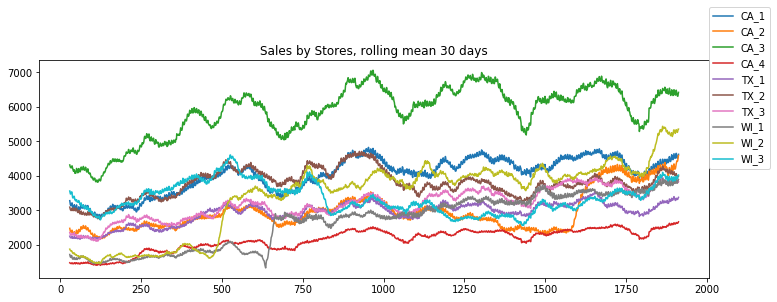

In [38]:
# Sales by Stores (with rolling mean 30)
plt.figure(figsize=(12, 8))
dept_grouped_sales = train_sales.groupby(['store_id']).sum()
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.values, label=i);
plt.legend(loc=(1.0, 0.5))
plt.title('Sales by Stores');

plt.figure(figsize=(12, 4))
for i, row in dept_grouped_sales.iterrows():
    plt.plot(row.rolling(30).mean().values, label=i);
plt.title('Sales by Stores, rolling mean 30 days')
plt.legend(loc=(1.0, 0.5));

In [39]:
calendar.head()

,date,wm_yr_wk,weekday,wday,month,year,d,event_name_1,event_type_1,event_name_2,event_type_2,snap_CA,snap_TX,snap_WI
0,2011-01-29,11101,Saturday,1,1,2011,d_1,NaN,NaN,NaN,NaN,0,0,0
1,2011-01-30,11101,Sunday,2,1,2011,d_2,NaN,NaN,NaN,NaN,0,0,0
2,2011-01-31,11101,Monday,3,1,2011,d_3,NaN,NaN,NaN,NaN,0,0,0
3,2011-02-01,11101,Tuesday,4,2,2011,d_4,NaN,NaN,NaN,NaN,1,1,0
4,2011-02-02,11101,Wednesday,5,2,2011,d_5,NaN,NaN,NaN,NaN,1,0,1


In [40]:
# Delete unnecessary variables, fill nan and encode
from sklearn.preprocessing import OrdinalEncoder

def prep_calendar(df):
    df = df.drop(["date", "weekday", "event_name_2", "event_type_2"], axis=1)
    df = df.assign(d = df.d.str[2:].astype(int))
    to_ordinal = ["event_name_1", "event_type_1"] 
    df[to_ordinal] = df[to_ordinal].fillna("1")
    df[to_ordinal] = OrdinalEncoder(dtype="int").fit_transform(df[to_ordinal]) + 1
    to_int8 = ["wday", "month", "snap_CA", "snap_TX", "snap_WI"] + to_ordinal
    df[to_int8] = df[to_int8].astype("int8")
    return df

calendar = prep_calendar(calendar)
calendar.head()

,wm_yr_wk,wday,month,year,d,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI
0,11101,1,1,2011,1,1,1,0,0,0
1,11101,2,1,2011,2,1,1,0,0,0
2,11101,3,1,2011,3,1,1,0,0,0
3,11101,4,2,2011,4,1,1,1,1,0
4,11101,5,2,2011,5,1,1,1,0,1


In [41]:
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price
0,CA_1,HOBBIES_1_001,11325,9.58
1,CA_1,HOBBIES_1_001,11326,9.58
2,CA_1,HOBBIES_1_001,11327,8.26
3,CA_1,HOBBIES_1_001,11328,8.26
4,CA_1,HOBBIES_1_001,11329,8.26


In [42]:
# Create a new feature that is price difference
def zapsmall(z, tol=1e-6):
    z[abs(z) < tol] = 0
    return z
    
def prep_selling_prices(df):
    gr = df.groupby(["store_id", "item_id"])["sell_price"]
    df["sell_price_rel_diff"] = gr.pct_change()
    to_float32 = ["sell_price", "sell_price_rel_diff"]
    df[to_float32] = df[to_float32].astype("float32")
         
    return df

selling_prices = prep_selling_prices(selling_prices)
selling_prices.head()

,store_id,item_id,wm_yr_wk,sell_price,sell_price_rel_diff
0,CA_1,HOBBIES_1_001,11325,9.58,NaN
1,CA_1,HOBBIES_1_001,11326,9.58,0.000000
2,CA_1,HOBBIES_1_001,11327,8.26,-0.137787
3,CA_1,HOBBIES_1_001,11328,8.26,0.000000
4,CA_1,HOBBIES_1_001,11329,8.26,0.000000


In [43]:
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d_1,d_2,d_3,d_4,...,d_1904,d_1905,d_1906,d_1907,d_1908,d_1909,d_1910,d_1911,d_1912,d_1913
0,HOBBIES_1_001_CA_1_validation,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,3,0,1,1,1,3,0,1,1
1,HOBBIES_1_002_CA_1_validation,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,0,0,0,0,0,1,0,0,0,0
2,HOBBIES_1_003_CA_1_validation,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,2,1,1,1,0,1,1,1
3,HOBBIES_1_004_CA_1_validation,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,1,0,5,4,1,0,1,3,7,2
4,HOBBIES_1_005_CA_1_validation,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,0,0,0,0,...,2,1,1,0,1,1,2,2,2,4


In [44]:
# Make sales from wide to long and keep only data from 1200 day
def reshape_sales(df, drop_d = None):
    if drop_d is not None:
        df = df.drop(["d_" + str(i+1) for i in range(drop_d-1)], axis=1)
        df = df.assign(id=df.id.str.replace("_validation", ""))
        df = df.reindex(columns=df.columns.tolist() + ["d_" + str(1913 + i + 1) for i in range(2 * 28)])
        df = df.melt(id_vars=["id", "item_id", "dept_id", "cat_id", "store_id", "state_id"],
                 var_name='d', value_name='demand')
        df = df.assign(d=df.d.str[2:].astype("int64"))

    return df

sales = reshape_sales(sales, 1200)

In [45]:
sales.head(150)

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1200,0.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1200,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1200,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1200,3.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1200,1.0
...,...,...,...,...,...,...,...,...
145,HOBBIES_1_150_CA_1,HOBBIES_1_150,HOBBIES_1,HOBBIES,CA_1,CA,1200,0.0
146,HOBBIES_1_151_CA_1,HOBBIES_1_151,HOBBIES_1,HOBBIES,CA_1,CA,1200,0.0
147,HOBBIES_1_152_CA_1,HOBBIES_1_152,HOBBIES_1,HOBBIES,CA_1,CA,1200,1.0
148,HOBBIES_1_153_CA_1,HOBBIES_1_153,HOBBIES_1,HOBBIES,CA_1,CA,1200,1.0


In [46]:
# Create time-related features
def prep_sales(df):
    df['lag_t28'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28))
    df['rolling_mean_t7'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(7).mean())
    df['rolling_mean_t15'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(15).mean())
    df['rolling_mean_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).mean())
    df['rolling_mean_t50'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(50).mean())
    df['rolling_mean_t70'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(70).mean())
    df['rolling_mean_t150'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(150).mean())
    df['rolling_mean_t180'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(180).mean())
    df['rolling_std_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).std())
    df['rolling_kurt_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).kurt())
    df['rolling_skew_t30'] = df.groupby(['id'])['demand'].transform(lambda x: x.shift(28).rolling(30).skew())
    to_float32 = ['lag_t28', "rolling_mean_t7", "rolling_mean_t15", "rolling_mean_t30", 
     "rolling_mean_t50", "rolling_mean_t70", "rolling_mean_t150", "rolling_mean_t180", 
                  "rolling_std_t30", "rolling_kurt_t30","rolling_skew_t30"]
    df[to_float32] = df[to_float32].astype("float32")
    
    # Remove rows with NAs except for submission rows. rolling_mean_t180 was selected as it produces most missings
    df = df[(df.d >= 1914) | (pd.notna(df.rolling_mean_t180))]
 
    return df

sales = prep_sales(sales)

In [47]:
# Merge all the data and drop unnecessary variables
sales = sales.merge(calendar, how="left", on="d")
sales = sales.merge(selling_prices, how="left", on=["store_id", "item_id", "wm_yr_wk"])
sales.drop(["wm_yr_wk"], axis=1, inplace=True)
sales.head()

,id,item_id,dept_id,cat_id,store_id,state_id,d,demand,lag_t28,rolling_mean_t7,...,wday,month,year,event_name_1,event_type_1,snap_CA,snap_TX,snap_WI,sell_price,sell_price_rel_diff
0,HOBBIES_1_001_CA_1,HOBBIES_1_001,HOBBIES_1,HOBBIES,CA_1,CA,1407,1.0,0.0,0.428571,...,7,12,2014,1,1,1,1,1,8.26,0.0
1,HOBBIES_1_002_CA_1,HOBBIES_1_002,HOBBIES_1,HOBBIES,CA_1,CA,1407,0.0,1.0,0.571429,...,7,12,2014,1,1,1,1,1,3.97,0.0
2,HOBBIES_1_003_CA_1,HOBBIES_1_003,HOBBIES_1,HOBBIES,CA_1,CA,1407,0.0,0.0,0.000000,...,7,12,2014,1,1,1,1,1,2.97,0.0
3,HOBBIES_1_004_CA_1,HOBBIES_1_004,HOBBIES_1,HOBBIES,CA_1,CA,1407,8.0,4.0,3.142857,...,7,12,2014,1,1,1,1,1,4.64,0.0
4,HOBBIES_1_005_CA_1,HOBBIES_1_005,HOBBIES_1,HOBBIES,CA_1,CA,1407,0.0,2.0,0.857143,...,7,12,2014,1,1,1,1,1,2.88,0.0


In [48]:
# Encode the variables left (_id)
for i, v in tqdm(enumerate(["item_id", "dept_id", "store_id", "cat_id", "state_id"])):
    sales[v] = OrdinalEncoder(dtype="int").fit_transform(sales[[v]]).astype("int16") + 1

In [49]:
# Features used
x = ["wday", "month", "year", 
     "event_name_1", "event_type_1",
     "snap_CA", "snap_TX", "snap_WI",
     "sell_price", "sell_price_rel_diff",
     "lag_t28", "rolling_mean_t7", "rolling_mean_t15", "rolling_mean_t30", 
     "rolling_mean_t50", "rolling_mean_t70", "rolling_mean_t150", "rolling_mean_t180",
     "rolling_std_t30", "rolling_skew_t30", "rolling_kurt_t30",
     "item_id", "dept_id", "cat_id", "store_id", "state_id"]

In [50]:
# Split test and train sets
test = sales[(sales.d >= 1914)]
test = test.assign(id=test.id + "_" + np.where(test.d <= 1941, "validation", "evaluation"),
                   F="F" + (test.d - 1913 - 28 * (test.d > 1941)).astype("str"))

train = sales[sales.d < 1914]
gc.collect()

71

In [51]:
train = train.drop(["d", "id"], axis=1)

In [52]:
train.isnull().sum()

item_id                      0
dept_id                      0
cat_id                       0
store_id                     0
state_id                     0
demand                       0
lag_t28                      0
rolling_mean_t7              0
rolling_mean_t15             0
rolling_mean_t30             0
rolling_mean_t50             0
rolling_mean_t70             0
rolling_mean_t150            0
rolling_mean_t180            0
rolling_std_t30              0
rolling_kurt_t30       1739129
rolling_skew_t30       1739129
wday                         0
month                        0
year                         0
event_name_1                 0
event_type_1                 0
snap_CA                      0
snap_TX                      0
snap_WI                      0
sell_price              126599
sell_price_rel_diff     134254
dtype: int64

In [53]:
# Features used in the benchmark
basex = ["wday", "month", "year", 
     "event_name_1", "event_type_1",
     "snap_CA", "snap_TX", "snap_WI",
     "sell_price",
     "item_id", "dept_id", "cat_id", "store_id", "state_id"]

In [63]:
# Fill nan with mean to fit the model
train.sell_price.fillna(train.sell_price.mean(),inplace=True)

In [64]:
# train test split
from sklearn.model_selection import train_test_split
X_trainb,X_testb,y_trainb,y_testb =train_test_split(train[basex],train.demand,test_size=0.1)

In [79]:
# Linear regression fit
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit( X_trainb, y_trainb )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [80]:
# Prediction
lm_test_pred = lm.predict(X_testb)

In [81]:
# RMSE
from sklearn.metrics import mean_squared_error
rmselm = mean_squared_error(y_testb,lm_test_pred,squared=False)
rmselm

3.4438883923732444

In [82]:
# R2
from sklearn import linear_model
reg = linear_model.Ridge(alpha=5000)
reg.fit(X_trainb, y_trainb ) 
print('R2 for Train)', reg.score( X_trainb, y_trainb ))
print('R2 for Test (cross validation)', reg.score(X_testb, y_testb))

R2 for Train) 0.027906520466812412
R2 for Test (cross validation) 0.028487952484513638


In [74]:
# Fill nan to fit the model
# Use 0 in sell_price_rel_diff since there are a lot of zeros in this variable
train.sell_price_rel_diff.fillna(0,inplace=True)
train.rolling_skew_t30.fillna(train.rolling_skew_t30.mean(),inplace=True)
train.rolling_kurt_t30.fillna(train.rolling_kurt_t30.mean(),inplace=True)

In [75]:
# Same
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(train[x],train.demand,test_size=0.1)

In [76]:
from sklearn.linear_model import LinearRegression
lm = LinearRegression()
lm.fit( X_train, y_train )

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [77]:
lm_test_pred = lm.predict(X_test)

In [78]:
from sklearn.metrics import mean_squared_error
rmselm = mean_squared_error(y_test,lm_test_pred,squared=False)
rmselm

2.366961826665622

In [180]:
from sklearn import linear_model
reg = linear_model.Ridge(alpha=5000)
reg.fit(X_train, y_train ) 
print('R2 for Train)', reg.score( X_train, y_train ))
print('R2 for Test (cross validation)', reg.score(X_test, y_test))

R2 for Train) 0.5639834114415184
R2 for Test (cross validation) 0.5646472478732505


In [181]:
# Feature Importance
pd.DataFrame( list(zip(x, reg.coef_)),
            columns=['features', 'estimatedCoeffs'])

,features,estimatedCoeffs
0,wday,-0.053125
1,month,-0.008310
2,year,0.015502
3,event_name_1,-0.000073
4,event_type_1,-0.025705
5,snap_CA,0.042832
6,snap_TX,0.053474
7,snap_WI,0.043723
8,sell_price,-0.003084
9,sell_price_rel_diff,0.001068


In [83]:
import lightgbm as lgb

In [103]:
train = sales[sales.d < 1914]

In [104]:
from sklearn.model_selection import train_test_split
X_train,X_test,y_train,y_test =train_test_split(train[x],train.demand,test_size=0.04)

In [105]:
# Convert them into dataset to fit the model
valid = lgb.Dataset(X_test, label = y_test)
train = lgb.Dataset(X_train, label = y_train)

In [106]:
# Parameters tuning and fit
lgb_params = {
                    'objective': 'tweedie',
                    'metric':'rmse',
                    'force_row_wise':True,
                    'learning_rate':0.03,
                    'sub_feature':0.8,
                    'sub_row':0.75,
                    'bagging_freq':1,
                    'lambda_12':0.1,
                    'metric':['rmse'],
                    'nthread':8,
                    'tweedie_variance_power':1.2,
                    'verbosity':1,'num_iterations':3000,'num_levels':128,'min_date_in_leaf':104, 
                }

fit = lgb.train(lgb_params, 
                train, 
                valid_sets = [valid], 
                verbose_eval = 50)

[50]	valid_0's rmse: 2.52317
[100]	valid_0's rmse: 2.31687
[150]	valid_0's rmse: 2.27352
[200]	valid_0's rmse: 2.25271
[250]	valid_0's rmse: 2.24117
[300]	valid_0's rmse: 2.22996
[350]	valid_0's rmse: 2.21968
[400]	valid_0's rmse: 2.21228
[450]	valid_0's rmse: 2.20682
[500]	valid_0's rmse: 2.20229
[550]	valid_0's rmse: 2.19761
[600]	valid_0's rmse: 2.19273
[650]	valid_0's rmse: 2.1871
[700]	valid_0's rmse: 2.18007
[750]	valid_0's rmse: 2.17547
[800]	valid_0's rmse: 2.17123
[850]	valid_0's rmse: 2.16678
[900]	valid_0's rmse: 2.16153
[950]	valid_0's rmse: 2.15848
[1000]	valid_0's rmse: 2.15353
[1050]	valid_0's rmse: 2.15053
[1100]	valid_0's rmse: 2.14657
[1150]	valid_0's rmse: 2.14358
[1200]	valid_0's rmse: 2.14077
[1250]	valid_0's rmse: 2.13777
[1300]	valid_0's rmse: 2.13513
[1350]	valid_0's rmse: 2.13226
[1400]	valid_0's rmse: 2.1301
[1450]	valid_0's rmse: 2.12785
[1500]	valid_0's rmse: 2.12556
[1550]	valid_0's rmse: 2.12349
[1600]	valid_0's rmse: 2.12151
[1650]	valid_0's rmse: 2.11987

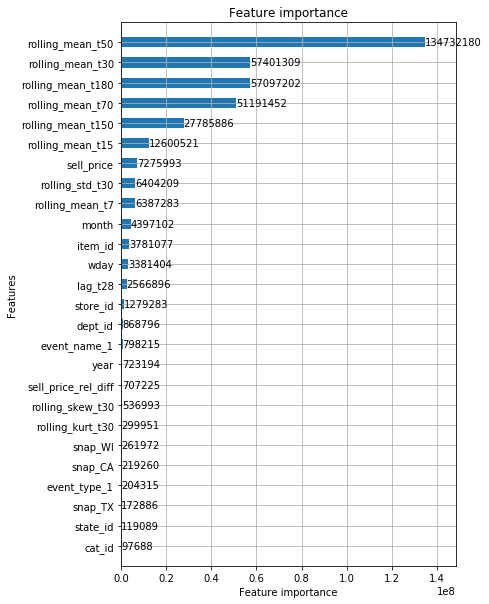

In [107]:
# Feature Importance
lgb.plot_importance(fit, importance_type="gain", precision=0, height=0.5, figsize=(6, 10));

In [108]:
# Prediction
pred = fit.predict(test[x])

In [109]:
# Transform the prediction to fit the form of submission
# 1.447147 is used because we need to include a trend here
pred_calibrated = pred / pred[test["id"].str.endswith("validation")].mean() * 1.447147
test["demand"] = pred_calibrated
submission = test.pivot(index="id", columns="F", values="demand").reset_index()[sample_submission.columns]
submission.head()

F,id,F1,F2,F3,F4,F5,F6,F7,F8,F9,...,F19,F20,F21,F22,F23,F24,F25,F26,F27,F28
0,FOODS_1_001_CA_1_evaluation,0.236195,0.219155,0.225091,0.229139,0.262093,0.324799,0.304995,0.238016,0.219155,...,0.213455,0.233974,0.220082,0.181848,0.168928,0.170078,0.181478,0.204228,0.252021,0.237511
1,FOODS_1_001_CA_1_validation,0.796484,0.740002,0.753031,0.735561,0.992819,1.065722,1.077094,0.965518,0.956060,...,1.098793,1.326171,1.191512,1.046472,0.933341,0.954582,0.874692,1.074382,1.309727,1.163613
2,FOODS_1_001_CA_2_evaluation,0.223259,0.207685,0.215437,0.219312,0.253930,0.317631,0.295977,0.226492,0.207685,...,0.288852,0.343138,0.318354,0.240786,0.226820,0.230109,0.246101,0.280496,0.370460,0.327808
3,FOODS_1_001_CA_2_validation,0.837959,0.788634,0.782019,0.769963,0.899427,0.937033,0.724419,0.764753,0.833290,...,0.919368,1.017314,1.598511,0.969136,1.048615,1.036380,1.211446,1.202837,1.370595,1.543828
4,FOODS_1_001_CA_3_evaluation,0.254766,0.239388,0.249206,0.253578,0.270774,0.326487,0.309204,0.253867,0.239388,...,0.182529,0.199966,0.189432,0.157168,0.147207,0.150212,0.159862,0.170703,0.214594,0.206808


In [110]:
# Create a csv to submit
submission.to_csv("split_3000_0.03_size0.04.csv", index=False)

In [127]:
# This is the best model after parameter tuning
#fit.save_model("split3000.lgb")